# Binary classification with one hidden layer

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import pprint as pp

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

## Test data

(-3, 3)

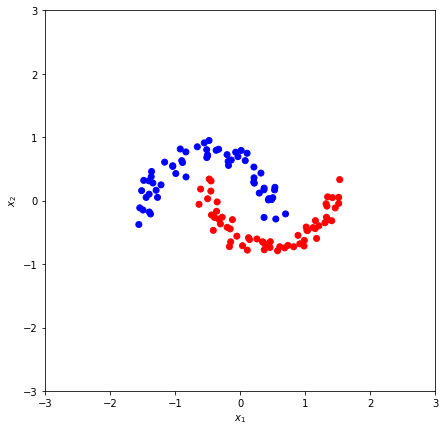

In [2]:
np.random.seed(0)

from sklearn import datasets
n_samples = 120
x, y = datasets.make_moons(n_samples=n_samples, random_state=0, noise=0.1)
x = x - np.mean(x,0) # 0 centered

plt.figure(figsize=(7,7))
plt.scatter(x[:,0], x[:,1], c=y, cmap=cm.bwr)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-3,3)
plt.ylim(-3,3)

## Torch dataset

We will create a dataset class that will be used by dataloader to present batches during training.

In [3]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = {
            'feature': torch.tensor(self.x[idx], dtype=torch.float32), 
            'label': torch.tensor(np.array([self.y[idx]]), dtype=torch.float32)}
        return sample

Testing our dataset.  

In [4]:
import pprint as pp

dataset = MyDataset(x, y)
print('length: ', len(dataset))
for i in range(5):
    pp.pprint(dataset[i])

length:  120
{'feature': tensor([-1.3389,  0.2798]), 'label': tensor([0.])}
{'feature': tensor([ 0.7349, -0.7039]), 'label': tensor([1.])}
{'feature': tensor([ 0.9834, -0.7139]), 'label': tensor([1.])}
{'feature': tensor([0.4425, 0.0330]), 'label': tensor([0.])}
{'feature': tensor([ 0.8904, -0.5459]), 'label': tensor([1.])}


Using dataloader to construct batches for training purposes

In [5]:
dataset = MyDataset(x, y)
batch_size = 4
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
for i_batch, samples in enumerate(dataloader):
    print('\nbatch# = %s' % i_batch)
    print('samples: ')
    pp.pprint(samples)
    break # Otherwise it prints too much stuff


batch# = 0
samples: 
{'feature': tensor([[ 0.3456, -0.6479],
        [-1.3969,  0.1039],
        [ 0.4425,  0.0330],
        [ 0.0796,  0.6330]]),
 'label': tensor([[1.],
        [0.],
        [0.],
        [0.]])}


## Logistic regression model

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        
        num_classes = 2

        # input layer
        self.linear1 = nn.Linear(input_size, 7)
        self.tan1 = nn.Tanh()
        
        # hidden layer
        self.linear2 = nn.Linear(7, 7)
        self.tan2 = nn.Tanh()
        
        # output layer -- Sigmoid since we are interested in classification
        self.linear3 = nn.Linear(7, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        
        # input layer
        out = self.tan1(self.linear1(x))
        
        # hidden layer
        out = self.tan2(self.linear2(out))

        # output layer -- Sigmoid since we are interested in classification
        out = self.sigmoid(self.linear3(out))
        
        return out

## Loss

In [7]:
import torch.nn as nn
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        
    def forward(self, predictions, targets):
        n = len(predictions)
        return torch.sum((torch.abs(torch.sub(targets,predictions))))

## Accuracy

Counting how many predictions were correct.

In [8]:
def accuracy(predictions, labels):
    l = labels.type(torch.ByteTensor)
    p = (predictions > 0.5)
    s = torch.sum(p.eq(l))
    return s.item()

## Training

In [11]:
import torch.nn.functional as F

model = LogisticRegression(2)
criterion = MyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  

dataset = MyDataset(x, y)
batch_size = 16
shuffle = True
num_workers = 4
training_sample_generator = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

num_epochs = 1000
for epoch in range(num_epochs):
    n = 0
    for batch_i, samples in enumerate(training_sample_generator):
        predictions = model(samples['feature'])
        error = criterion(predictions, samples['label'])
        n += accuracy(predictions, samples['label'])
        optimizer.zero_grad()
        error.backward()        
        optimizer.step()
    if epoch % 50 == 0:
        print('epoch %d:' % epoch, error.item())
        print('accuracy', n)
    if n > 119:
        break

epoch 0: 3.765061616897583
accuracy 60
epoch 50: 1.8585937023162842
accuracy 108
epoch 100: 0.35147538781166077
accuracy 109
epoch 150: 0.21965743601322174
accuracy 109
epoch 200: 0.1253092736005783
accuracy 109
epoch 250: 1.9960203170776367
accuracy 109
epoch 300: 1.0107163190841675
accuracy 109
epoch 350: 1.9978941679000854
accuracy 109
epoch 400: 0.0008965092711150646
accuracy 109
epoch 450: 0.0009148591780103743
accuracy 110
epoch 500: 0.006889374461025
accuracy 110
epoch 550: 0.8189349174499512
accuracy 114
epoch 600: 0.009289291687309742
accuracy 117
epoch 650: 0.05355709046125412
accuracy 117


## Visualizing results

torch.Size([1, 2500])
torch.Size([1, 2500])
torch.Size([2500, 2])
torch.Size([2500, 1])
(50, 50)
[0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0
 1 0 1 1 1 1 1 0 0]


Text(0.5,1,'Classification results')

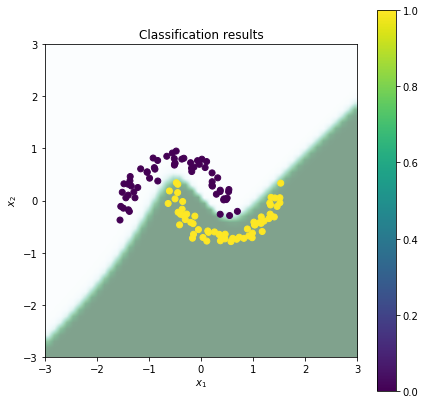

In [12]:
xcoord = np.linspace(-3, 3)
ycoord = np.linspace(-3, 3)
xx, yy = np.meshgrid(xcoord, ycoord)
xxt = torch.tensor(xx, dtype=torch.float32).view(-1).unsqueeze(0)
yyt = torch.tensor(yy, dtype=torch.float32).view(-1).unsqueeze(0)
print(xxt.shape)
print(yyt.shape)
v = torch.t(torch.cat([xxt,yyt]))
print(v.shape)
m = model(v)
print(m.shape)
mm = m.detach().numpy().reshape(50,50)
print(mm.shape)

x_try = torch.tensor(x, dtype=torch.float32)
y_try = model(x_try)
yy_try = (y_try.squeeze() > 0.5).numpy()
print(yy_try)

plt.figure(figsize=(7,7))
extent = -3, 3, -3, 3
plt.imshow(mm, cmap=cm.BuGn, interpolation='bilinear', extent=extent, alpha=.5, origin='lower')
plt.scatter(x[:,0], x[:,1], c=yy_try, cmap=cm.viridis)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('Classification results')